In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'

In [2]:
# 20 nodes JSRUN
exp1_sessions = pd.read_csv('../data/exp1/sessions.csv', index_col=0)
exp1_pilots = pd.read_csv('../data/exp1/pilots.csv', index_col=0)
exp1_units = pd.read_csv('../data/exp1/units.csv', index_col=0)

In [3]:
# Cleanup Exp4 spurious runs
# exp4_sessions.drop('rp.session.login4.mturilli1.018122.0001', axis=0, inplace=True)
# exp4_sessions.drop('rp.session.login4.mturilli1.018122.0000', axis=0, inplace=True)
# exp4_sessions.drop('rp.session.login4.mturilli1.018127.0003', axis=0, inplace=True)

In [4]:
print 'Experiment 1: Baseline: Total number of successful runs: %s' % exp1_sessions.shape[0]
print 'Experiment 1: Baseline: Total number of pilots: %s' % exp1_pilots.shape[0]
print 'Experiment 1: Baseline: Total number of units: %s\n' % exp1_units.shape[0]

Experiment 1: Baseline: Total number of successful runs: 1
Experiment 1: Baseline: Total number of pilots: 1
Experiment 1: Baseline: Total number of units: 736



In [5]:
exp1_sessions['nnode'] = exp1_sessions.ncore/168
exp1_sessions['list'] = exp1_sessions[['nunit','nnode']].astype(int, errors='ignore').astype('str').values.tolist()
exp1_sessions['nunitnode'] = exp1_sessions['list'].apply('/'.join)

exp1_ws = exp1_sessions[['nunit','nunitnode','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING',
                         'U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING',
                         'cu_exec_start_stop','nunit_failed']
                       ].groupby(['nunit','nunitnode']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std'],
                 'cu_exec_start_stop'  : ['mean','std'],
                 'nunit_failed'        : ['mean']
                })

exp1_ws.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
exp1_ws.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
exp1_ws.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
exp1_ws.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
exp1_ws.rename({'U_AGENT_EXECUTING'   :'TTX Agent'}, axis='columns', inplace=True)
exp1_ws.rename({'cu_exec_start_stop'  :'TTX Unit'}, axis='columns', inplace=True)
exp1_ws = exp1_ws.sort_values("nunit")
exp1_ws

TTQ     nunit_failed           TTC     Agent scheduling          TTX Unit     Agent queueing     Agent queueing execution         TTX Agent    
                       mean std         mean          mean std             mean std          mean std           mean std                     mean std          mean std
nunit nunitnode                                                                                                                                                        
736   736/5      766.598583 NaN            2  1.566407e+09 NaN         2.108758 NaN  45038.155729 NaN       0.235149 NaN                10.577011 NaN  45083.610606 NaN

In [6]:
# Total agent time = 
#    ru.STATE: rp.AGENT_SCHEDULING             - ru.STATE: rp.AGENT_SCHEDULING_PENDING +
#    ru.STATE: rp.AGENT_EXECUTING_PENDING      - ru.STATE: rp.AGENT_SCHEDULING         +
#    ru.STATE: rp.AGENT_EXECUTING              - ru.STATE: rp.AGENT_EXECUTING_PENDING  +
#    ru.STATE: rp.AGENT_STAGING_OUTPUT_PENDING - ru.STATE: rp.AGENT_EXECUTING          -
#    ru.EVENT: 'cu_exec_stop'                  - ru.EVENT: 'cu_exec_start'
#
# Total task execution time = 900 (derived analytically from the time passed to stress)

oh1 = exp1_ws.copy(deep=True)
oh1.loc[:,('TTX Agent','mean')] = (oh1.loc[:,('Agent queueing','mean')]            + \
                                   oh1.loc[:,('Agent scheduling','mean')]          + \
                                   oh1.loc[:,('Agent queueing execution','mean')]) + \
                                  oh1.loc[:,('TTX Agent','mean')]                  - \
                                  oh1.loc[:,('TTX Unit','mean')]

oh1.loc[:,('nunit_failed','mean')] = oh1.loc[:,('nunit_failed','mean')].apply(np.ceil)

oh1.columns = [' '.join(col).strip() for col in oh1.columns.values]

oh1 = oh1.sort_values("nunit")
oh1 = oh1.reset_index()
oh1

,nunit,nunitnode,TTQ mean,TTQ std,nunit_failed mean,TTC mean,TTC std,Agent scheduling mean,Agent scheduling std,TTX Unit mean,TTX Unit std,Agent queueing mean,Agent queueing std,Agent queueing execution mean,Agent queueing execution std,TTX Agent mean,TTX Agent std
0,736,736/5,766.598583,NaN,2.0,1.566407e+09,NaN,2.108758,NaN,45038.155729,NaN,0.235149,NaN,10.577011,NaN,58.375794,NaN


/Users/mturilli/Virtualenvs/summit_jsrun_prte/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


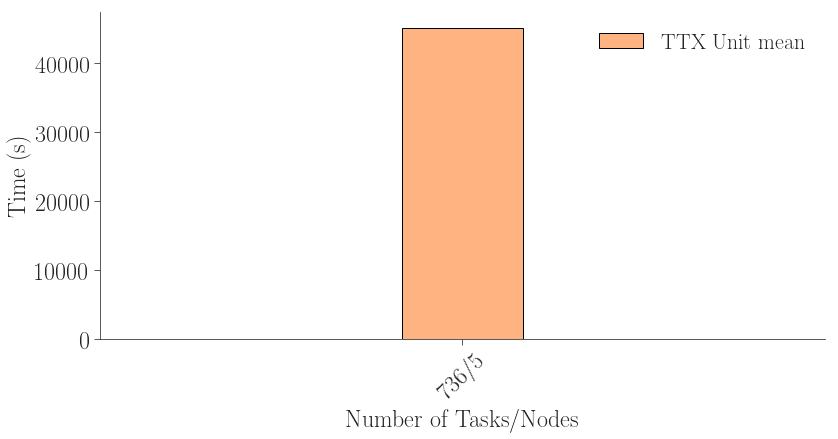

In [7]:
fig, ax = fig_setup(figsize=(13,6))

# oh = oh.fillna(0)

oh1.plot.bar(
    x = 'nunitnode', 
    y = 'TTX Unit mean', 
#     yerr= 'TTX Unit std',
#     logy=True,
#     stacked=True,
    width = 0.1, color = tableau20[3], ax = ax, rot = 45)

ax.set_xlabel('Number of Tasks/Nodes')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
# ax.set_xlim(-0.5)

plt.savefig('figures/paper_hyperrct_weak_scaling_ttx_subagent.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_hyperrct_weak_scaling_ttx_subagent.png', dpi=300, bbox_inches='tight')

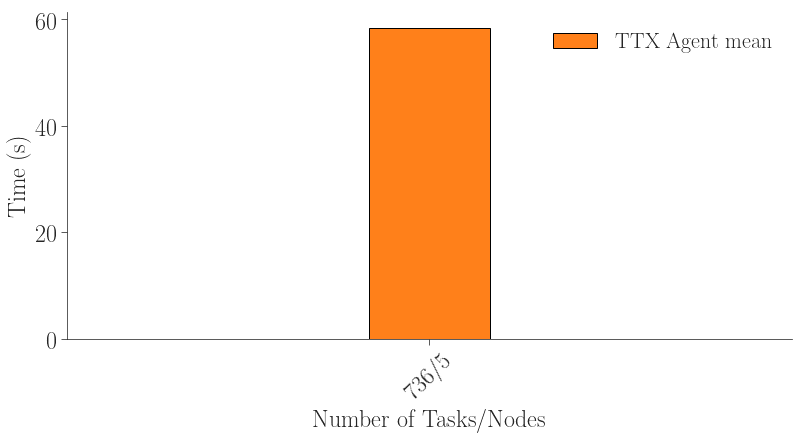

In [8]:
fig, ax = fig_setup(figsize=(13,6))

# oh = oh.fillna(0)

oh1.plot.bar(
    x = 'nunitnode', 
    y = 'TTX Agent mean', 
#     yerr = 'TTX Agent std']],
#     logy=True,
#     stacked=True,
    width=0.1, color=tableau20[2], ax=ax, rot=45)


ax.set_xlabel('Number of Tasks/Nodes')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
# ax.set_xlim(-0.5)

plt.savefig('figures/paper_hyperrct_weak_scaling_rp_overhead_subagent.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_hyperrct_weak_scaling_rp_overhead_subagent.png', dpi=300, bbox_inches='tight')

In [9]:
# oh4_prrte.rename({'sending launch msg mean': 'pending app launch $>$ sending launch msg'}, axis='columns', inplace=True)
# oh4_prrte.rename({'prte running 0 mean'    : 'sending launch msg $>$ running'}, axis='columns', inplace=True)
# oh4_prrte.rename({'notify completed mean'  : 'normally terminated $>$ notify completed'}, axis='columns', inplace=True)

# oh4_prrte['other'] = (oh4_prrte['pending allocation mean']        + \
#                       oh4_prrte['allocation complete mean']       + \
#                       oh4_prrte['pending daemon launch mean']     + \
#                       oh4_prrte['all daemons reported mean']      + \
#                       oh4_prrte['vm ready mean']                  + \
#                       oh4_prrte['pending mapping mean']           + \
#                       oh4_prrte['prte map complete mean']         + \
#                       oh4_prrte['pending final system prep mean'] + \
#                       oh4_prrte['pending app launch mean']        + \
#                       oh4_prrte['launch complete mean']           + \
#                       oh4_prrte['prte running 1 mean']            + \
#                       oh4_prrte['prte running 2 mean']            + \
#                       # oh4_prrte['iof complete mean']            + \
#                       oh4_prrte['waitpid fired mean']             + \
#                       oh4_prrte['normally terminated 0 mean']     + \
#                       oh4_prrte['normally terminated 1 mean']     + \
#                       oh4_prrte['normally terminated 2 mean'])

In [10]:
# fig, ax = fig_setup(figsize=(13,4))

# oh4_prrte.plot.bar(x='nunitnode', 
#                    y=[
# #                       'pending allocation mean', 
# #                       'allocation complete mean', 
# #                       'pending daemon launch mean', 
# #                       'all daemons reported mean', 
# #                       'vm ready mean', 
# #                       'pending mapping mean', 
# #                       'prte map complete mean', 
# #                       'pending final system prep mean', 
# #                       'pending app launch mean', 
#                       'pending app launch $>$ sending launch msg', #'sending launch msg mean', 
#                       'sending launch msg $>$ running',            # 'prte running 0 mean', 
# #                       'launch complete mean', 
# #                       'prte running 1 mean', 
# #                       'prte running 2 mean', 
# #                       'iof complete mean', 
# #                       'waitpid fired mean', 
# #                       'normally terminated 0 mean',
# #                       'normally terminated 1 mean', 
# #                       'normally terminated 2 mean', 
#                       'normally terminated $>$ notify completed', # 'notify completed mean',
#                       'other'],
# #                  yerr=oh4_prrte.filter(like='std'),
#                    stacked=True, 
# #                  logy=True, 
#                    width=0.5, color=[tableau20[12],tableau20[8],tableau20[16],tableau20[20]], ax=ax, rot=45)

# ax.set_xlabel('Number of Tasks/Nodes')
# ax.set_ylabel('Time (s)')

# plt.savefig('figures/paper_prrte_weak_scaling_prrte_events.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/paper_prrte_weak_scaling_prrte_events.png', dpi=300, bbox_inches='tight')

In [11]:
# Load sessions for Synapse experiment 1
ws_sras = load_sessions_units(
    '../data',       # session directory  
    exp1_sessions,   # sessions
    sorted(exp1_sessions.nunit.unique().tolist()) # session nunits
)

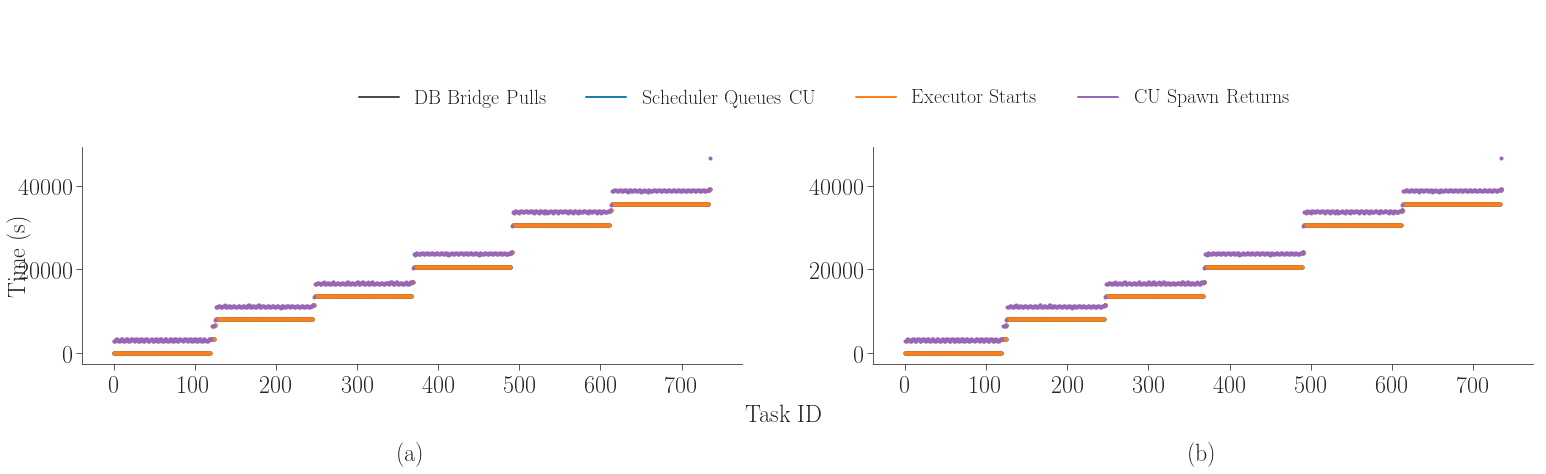

In [12]:
nunits = [736,736]
fwidth = 26
fhight = 4
fig, axarr = plt.subplots(1, len(nunits), sharex='col', figsize=(fwidth,fhight))#, sharey='row')

i = 0
j = 'a'
for nunit in nunits:
    session  = ws_sras[nunit][0]

    # Get events and order them by Scheduling
    df = get_df_unit_events(session)
    df = df.sort_values(by='Scheduler Queues CU')
    df = df.reset_index(drop=True)
    
    # 'Executable Starts'       , 'Executable Stops'     ,
    
    df = df[['Scheduler Starts Schedule' , 'Scheduler Stops Schedule', 'Scheduler Queues CU'  , 'Executor Starts'            ,
             'Executor Starts Mkdir'     , 'Executor Stops Mkdir'    , 'Executor Spawns CU'   , 'OS Accepts Spawned CU'      ,
             'OS Spawns CU'              , 'CU Changes Dir'          , 'CU Starts Pre-execute', 'CU Stops Pre-execute'       ,
             'CU Spawns Executable'      , 'CU Spawn Returns'        ,
             'CU Starts Post-execute'    , 'CU Stops Post-execute'   , 'Executor Stops'       , 'Scheduler Starts Unschedule',
             'Scheduler Stops Unschedule', 'DB Bridge Pulls']]
    df = df.dropna(axis=1, how='all')
    df = df.sub(df['Scheduler Starts Schedule'][0])

    # Set axes properties
    ax = axarr[i]
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
#     unode = np.ceil(nunit/42.0)+1
#     nnode = unode+(int(np.ceil(unode/168.0)))
#     ax.title.set_text('%s/%s Tasks/Nodes' % (nunit, int(nnode)))

    # Plot data
    ax.scatter(df['DB Bridge Pulls'].index    , df['DB Bridge Pulls']    , marker='.', color=tableau20[18]) # Agent Scheduling Component
    ax.scatter(df['Scheduler Queues CU'].index, df['Scheduler Queues CU'], marker='.', color=tableau20[0] ) # Agent Scheduling Component
    ax.scatter(df['Executor Starts'].index    , df['Executor Starts']    , marker='.', color=tableau20[2] ) # Agent Executing Component
    # ax.scatter(df['Executable Starts'].index  , df['Executable Starts']  , marker='.', color=tableau20[4] ) # Synapse
    # ax.scatter(df['Executable Stops'].index   , df['Executable Stops']   , marker='.', color=tableau20[6] ) # Synapse, orterun [orterun spawner]
    ax.scatter(df['CU Spawn Returns'].index   , df['CU Spawn Returns']   , marker='.', color=tableau20[8] ) # CU script
    
    # Add subfigure label and increment counters
    ax.set_xlabel('(%s)' % j, labelpad=45)
    i = i+1
    j = chr(ord(j) + 1)

# Add common axes lables
fig.text(0.085, 0.5, 'Time (s)', va='center', rotation='vertical', fontsize=24)
fig.text(0.5, -0.08, 'Task ID', ha='center', fontsize=24)
    
# Add common legend with f* proxy artists (https://matplotlib.org/users/legend_guide.html)
fig.legend((
                mpl.lines.Line2D([], [], color=tableau20[18]),
                mpl.lines.Line2D([], [], color=tableau20[0] ), 
                mpl.lines.Line2D([], [], color=tableau20[2] ),
                # mpl.lines.Line2D([], [], color=tableau20[4] ), 
                # mpl.lines.Line2D([], [], color=tableau20[6] ),
                mpl.lines.Line2D([], [], color=tableau20[8] )
           ),
           (
                'DB Bridge Pulls',
                'Scheduler Queues CU',
                'Executor Starts',
                # 'Executable Starts',
                # 'Executable Stops',
                'CU Spawn Returns',
           ), 
           'upper center',
           bbox_to_anchor=(0.44, 1.4),
           fontsize=20,
           ncol=6)

plt.savefig('figures/paper_prrte_weak_scaling_rp_events_timeline.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/paper_prrte_weak_scaling_rp_events_timeline.png', dpi=300, bbox_inches='tight')